<a href="https://colab.research.google.com/github/TongleiChen/sketch_to_image/blob/main/COSC576_project_happy_thanksgiving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from io import BytesIO # Use When expecting bytes-like objects
import pickle
from collections import OrderedDict
import os
from os import path
import ast
import random



from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import os
import matplotlib.pyplot as plt

# from torch_snippets import *
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms



from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title Run before download from Kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"yuni000","key":"cab374f6862b6a75afba7eecfc85931c"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

The following code reference: https://www.kaggle.com/code/aleksandradeis/getting-started-with-pytorch-for-quick-draw/notebook

In [11]:
#@title SKETCH CLASSIFICATION
categories = ["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"]
# categories = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {0:'bear',1:'camel', 2:'cat', 3:'dog', 4:'elephant',
                      5:'frog',6:'lion', 7:'panda', 8:'rabbit', 9:'squirrel'}

# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("./drive/MyDrive/kaggle/sketch/" + category + ".csv")
    classes[category] = data

In [14]:
# Image manipulation utilities: 

def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """
    
    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()
            
    draw = ImageDraw.Draw(pil_img)
    
    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)
        
    return pil_img


def convert_to_np_raw(drawing, width = 256, height = 256):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (28 X 28)
    """
    # initialize empty numpy array
    img = np.zeros((28, 28))
    
    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)
    
    #resize to 28,28
    pil_img.thumbnail((28,28), Image.ANTIALIAS)
    
    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255
    
    return img

def convert_to_np(pil_img, width = 256, height = 256):
    """
    Function to convert PIL Image to numpy array.
    INPUT:
        pil_img - (PIL Image) image to be converted
    OUTPUT:
        img - (numpy array) converted image with shape (width, height)
    """
    pil_img = pil_img.convert('RGB')

    img = np.zeros((width, height))
    pixels = pil_img.load()

    for i in range(0, width):
      for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def view_image(img, width = 256, height = 256):
    """
    Function to view numpy image with matplotlib.
    The function saves the image as png.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
    None
    """
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(width, height).squeeze())
    ax.axis('off')

    plt.show()
def crop_image(image):
    """
    Crops image (crops out white spaces).
    INPUT:
        image - PIL image of original size to be cropped
    OUTPUT:
        cropped_image - PIL image cropped to the center  and resized to (28, 28)
    """
    cropped_image = image

    # get image size
    width, height = cropped_image.size

    # get image pixels
    pixels = cropped_image.load()

    image_strokes_rows = []
    image_strokes_cols = []

    # run through the image
    for i in range(0, width):
        for j in range(0, height):
            # save coordinates of the image
            if (pixels[i,j][0] > 0):
                image_strokes_cols.append(i)
                image_strokes_rows.append(j)

    # if image is not empty then crop to contents of the image
    if (len(image_strokes_rows)) > 0:
        # find the box for image
        row_min = np.array(image_strokes_rows).min()
        row_max = np.array(image_strokes_rows).max()
        col_min = np.array(image_strokes_cols).min()
        col_max = np.array(image_strokes_cols).max()

        # find the box for cropping
        margin = min(row_min, height - row_max, col_min, width - col_max)

        # crop image
        border = (col_min, row_min, width - col_max, height - row_max)
        cropped_image = ImageOps.crop(cropped_image, border)

    # get cropped image size
    width_cropped, height_cropped = cropped_image.size

    # create square resulting image to paste cropped image into the center
    dst_im = Image.new("RGBA", (max(width_cropped, height_cropped), max(width_cropped, height_cropped)), "white")
    offset = ((max(width_cropped, height_cropped) - width_cropped) // 2, (max(width_cropped, height_cropped) - height_cropped) // 2)
    # paste to the center of a resulting image
    dst_im.paste(cropped_image, offset)

    #resize to 28,28
    dst_im.thumbnail((28,28), Image.ANTIALIAS)

    return dst_im
def normalize(arr):
    """
    Function performs the linear normalizarion of the array.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    INPUT:
        arr - orginal numpy array
    OUTPUT:
        arr - normalized numpy array
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def normalize_image(image):
    """
    Function performs the normalization of the image.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    INPUT:
        image - PIL image to be normalized
    OUTPUT:
        new_img - PIL image normalized
    """
    arr = np.array(image)
    new_img = Image.fromarray(normalize(arr).astype('uint8'),'RGBA')
    return new_img

def rotate_image(src_im, angle = 45, size = (28,28)):
    """
    Function to rotate PIL Image file
    INPUT:
        src_im - (PIL Image) 28x28 image to be rotated
        angle - angle to rotate the image
        size - (tuple) size of the output image
    OUTPUT:
    dst_im - (PIL Image) rotated image
    """
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im
def flip_image(src_im):
    """
    Function to flip a PIL Image file.
    INPUT:
        scr_im - (PIL Image) image to be flipped
    OUTPUT:
        dst_im - (PIL Image) flipped image
    """
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im


In [15]:
# shrinking the images

# create the dictionary containing classes names as keys and images as values
values_dict = {}
for category in categories:
    data = classes[category][:3000]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values
    
# concatenate to create X (values) and y (labels) datasets
X = []
y = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X.append(Xi)
    y.append(yi)
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

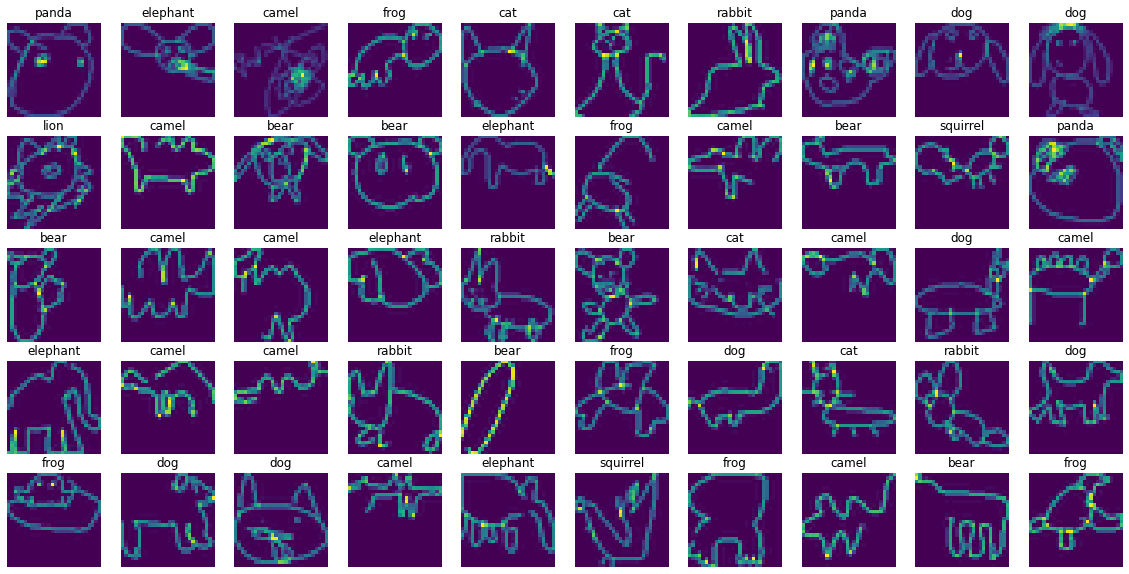

In [ ]:
# @title show sketch data image
def view_images_grid(X, y):
    """
    Function to plot grid with several examples of images.
    INPUT:
        X - (numpy array) images dataset
        y - (numpy array) labels for images from X dataset

    OUTPUT: None
    """
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[y[r_label]])
    plt.show()




view_images_grid(X, y)

In [9]:
def build_model(input_size, output_size, hidden_sizes, dropout = 0.0):
    '''
    Function creates deep learning model based on parameters passed.

    INPUT:
        input_size, output_size, hidden_sizes - layer sizes
        dropout - dropout (probability of keeping a node)

    OUTPUT:
        model - deep learning model
    '''

    # Build a feed-forward network
    model = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('bn2', nn.BatchNorm1d(num_features=hidden_sizes[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                          ('bn3', nn.BatchNorm1d(num_features=hidden_sizes[2])),
                          ('relu3', nn.ReLU()),
                          ('logits', nn.Linear(hidden_sizes[2], output_size))]))

    return model

def shuffle(X_train, y_train):
    """
    Function which shuffles training dataset.
    INPUT:
        X_train - (tensor) training set
        y_train - (tensor) labels for training set

    OUTPUT:
        X_train_shuffled - (tensor) shuffled training set
        y_train_shuffled - (tensor) shuffled labels for training set
        """
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0, optimizer = 'SGD'):
    """
    Function which fits the model.
    INPUT:
        model - pytorch model to fit
        X_train - (tensor) train dataset
        y_train - (tensor) train dataset labels
        epochs - number of epochs
        n_chunks - number of chunks to cplit the dataset
        learning_rate - learning rate value

    OUTPUT: None
    """

    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()

    if (optimizer == 'SGD'):
      optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 10

    steps = 0

    for e in range(epochs):
        running_loss = 0
        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if epochs % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            running_loss = 0
                
                
def view_classify(img, ps):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
    """
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()


def test_model(model, img):
    """
    Function creates test view of the model's prediction for image.

    INPUT:
        model - pytorch model
        img - (tensor) image from the dataset

    OUTPUT: None
    """

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    ps = get_preds(model, img)
    view_classify(img.resize_(1, 28, 28), ps)


def get_preds(model, input):
    """
    Function to get predicted probabilities from the model for each class.

    INPUT:
        model - pytorch model
        input - (tensor) input vector

    OUTPUT:
        ps - (tensor) vector of predictions
    """

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logits = model.forward(input)
    ps = F.softmax(logits, dim=1)
    return ps

def get_labels(pred):
    """
        Function to get the vector of predicted labels for the images in
        the dataset.

        INPUT:
            pred - (tensor) vector of predictions (probabilities for each class)
        OUTPUT:
            pred_labels - (numpy) array of predicted classes for each vector
    """

    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels
def evaluate_model(model, train, y_train, test, y_test):
    """
    Function to print out train and test accuracy of the model.

    INPUT:
        model - pytorch model
        train - (tensor) train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset

    OUTPUT:
        accuracy_train - accuracy on train dataset
        accuracy_test - accuracy on test dataset
    """
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test

def plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = 0.003, weight_decay = 0.0, dropout = 0.0, n_chunks = 1000, optimizer = 'SGD'):
    """
    Function to plot learning curve depending on the number of epochs.

    INPUT:
        input_size, output_size, hidden_sizes - model parameters
        train - (tensor) train dataset
        labels - (tensor) labels for train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset
        learning_rate - learning rate hyperparameter
        weight_decay - weight decay (regularization)
        dropout - dropout for hidden layer
        n_chunks - the number of minibatches to train the model
        optimizer - optimizer to be used for training (SGD or Adam)

    OUTPUT: None
    """
    train_acc = []
    test_acc = []

    for epochs in np.arange(10, 60, 10):
        # create model
        sketch_model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

        # fit model
        fit_model(sketch_model, train, labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay, optimizer = 'SGD')
        # get accuracy
        accuracy_train, accuracy_test = evaluate_model(sketch_model, train, y_train, test, y_test)

        train_acc.append(accuracy_train)
        test_acc.append(accuracy_test)

    
    return train_acc, test_acc, sketch_model

In [16]:
# Split dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [17]:
# Convert to tensors
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()
test = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(y_test).long()

# Set hyperparameters
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 10

dropout = 0.0
weight_decay = 0.0
n_chunks = 700
learning_rate = 0.03
optimizer = 'SGD'

In [ ]:

# Fit model
train_acc, test_acc, sketch_model = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = n_chunks, optimizer = optimizer)


Fitting model with epochs = 10, learning rate = 0.03

Epoch: 1/10...  Loss: 124.0034
Epoch: 2/10...  Loss: 104.1730
Epoch: 3/10...  Loss: 95.8537
Epoch: 4/10...  Loss: 89.4117
Epoch: 5/10...  Loss: 83.8945
Epoch: 6/10...  Loss: 79.1471
Epoch: 7/10...  Loss: 74.8316
Epoch: 8/10...  Loss: 70.5373
Epoch: 9/10...  Loss: 67.2386
Epoch: 10/10...  Loss: 63.6154
Accuracy score for train set is 0.7766190476190477 

Accuracy score for test set is 0.5265555555555556 

Fitting model with epochs = 20, learning rate = 0.03

Epoch: 1/20...  Loss: 122.9567
Epoch: 2/20...  Loss: 103.3156
Epoch: 3/20...  Loss: 95.1584
Epoch: 4/20...  Loss: 88.7916
Epoch: 5/20...  Loss: 83.1866
Epoch: 6/20...  Loss: 78.6274
Epoch: 7/20...  Loss: 74.3884
Epoch: 8/20...  Loss: 70.4026
Epoch: 9/20...  Loss: 66.9723
Epoch: 10/20...  Loss: 64.1496
Epoch: 11/20...  Loss: 60.4821
Epoch: 12/20...  Loss: 57.9837
Epoch: 13/20...  Loss: 55.3689
Epoch: 14/20...  Loss: 53.0829
Epoch: 15/20...  Loss: 50.8909
Epoch: 16/20...  Loss: 47.

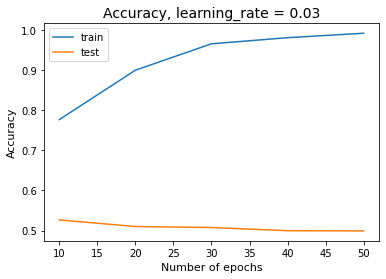

In [ ]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

In [ ]:
# @title Save sketch model
sketch_model_path = "/content/drive/MyDrive/kaggle/sketch"+'/cnn_model_sketch_epoch50_lr003.pth'
torch.save(sketch_model, sketch_model_path)

In [4]:
# @title Load sketch model
sketch_model_path = "/content/drive/MyDrive/kaggle/sketch"+'/cnn_model_sketch_epoch50_lr003.pth'
sketch_model=torch.load(sketch_model_path)



VGG reference: 
https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [6]:
# @title IMAGE CLASSIFICATION
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler


import random
import pandas as pd

from torchvision import transforms, utils

class ImageDataset(Dataset):

    def __init__(self, img_dir, animal_category, image_size = 255, class_size = 100,transform = False):
        """
        Args:
            sketch_dir (string): Directory to all the sketch images.
            realworld_dir (string): Directory to all the real world images.
            animal_category: list to fruit catogory
            class_size: Num of images in each category
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.animal_category = animal_category
        self.class_size = class_size
        self.data_dict = dict(np.load(img_dir,allow_pickle=True))
        self.image_size = image_size
       

        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize((image_size,image_size)),
                                                transforms.ToTensor(),])
                                              # transforms.Normalize( mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.animal_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.animal_category[class_index]
        category_idx = int(idx % self.class_size)
        label = np.zeros((len(self.animal_category), 1))
        label[class_index] = 1
        
#         label = class_index
        image_ary =  self.data_dict[category][category_idx]
        sample = {'image': image_ary, 'label': label}
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample
        
#@title 
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*2*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
      
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        out = self.fc1(out)
        out = self.fc2(out)
        return out
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample
  

In [ ]:
num_classes = 10
num_epochs = 30
batch_size = 64
learning_rate = 0.01 #0.03

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(image_model.parameters(), lr=learning_rate, weight_decay = 0.007, momentum = 0.9)  
LOAD = False

In [ ]:
QURIES = ["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"]  

train_realworld_dir = "/content/drive/MyDrive/kaggle/imagenet/all_images.npz"
train_realworld = ImageDataset(train_realworld_dir, QURIES, image_size = 64, class_size = 500,transform = True)
train_loader = DataLoader(train_realworld, batch_size=128, shuffle=True, pin_memory=True)

test_realworld_dir = "/content/drive/MyDrive/kaggle/imagenet/test_images.npz"
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 64, class_size = 10,transform = True)
test_loader_realworld = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True)

In [ ]:
start_epoch =0
train_realworld_acc = []
train_realworld_loss = []
val_realworld_acc = []
val_realworld_loss = []

In [ ]:
import gc
total_step = len(train_loader)

for epoch in range(start_epoch,start_epoch+num_epochs):
    for data in train_loader:  
        # Move tensors to the configured device
        images = data['image'].to(device)
        labels = data['label'].to(device)
        correct_t = 0
        total_t = 0
        # Forward pass
        image_model.train()
        outputs = image_model(images)
        loss = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
        _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
        total_t += labels.size(0)
        correct_t +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    
    train_realworld_loss.append(loss.item())
    train_realworld_acc.append(correct_t/total_t)
    print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                   .format(epoch+1,start_epoch+num_epochs, loss.item()))
            
    # Validation
    
    with torch.no_grad():
        image_model.eval()
        correct_v = 0
        total_v = 0
        for data in test_loader_realworld:
            images = data['image'].to(device)
            labels = data['label'].to(device)
        

            outputs = image_model(images)
            loss_v = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
   
            _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
            total_v += labels.size(0)
            correct_v +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
            
            del images, labels, outputs
        val_realworld_loss.append(loss_v.item())
        val_realworld_acc.append(correct_v/total_v)
        print(f"Validation accuracy: {(correct_v/total_v):.3f}")
       
print(f"train_acc:{(np.mean([v for v in train_realworld_acc])):.3f},val_acc:{(np.mean([v for v in val_realworld_acc])):.3f}")

Epoch [1/30], Training Loss: 2.0196
Validation accuracy: 0.230
Epoch [2/30], Training Loss: 1.4456
Validation accuracy: 0.330
Epoch [3/30], Training Loss: 1.3417
Validation accuracy: 0.370
Epoch [4/30], Training Loss: 1.5497
Validation accuracy: 0.350
Epoch [5/30], Training Loss: 0.8078
Validation accuracy: 0.390
Epoch [6/30], Training Loss: 2.4322
Validation accuracy: 0.430
Epoch [7/30], Training Loss: 1.2637
Validation accuracy: 0.450
Epoch [8/30], Training Loss: 2.1147
Validation accuracy: 0.390
Epoch [9/30], Training Loss: 0.9995
Validation accuracy: 0.490
Epoch [10/30], Training Loss: 1.1308
Validation accuracy: 0.520
Epoch [11/30], Training Loss: 1.5144
Validation accuracy: 0.480
Epoch [12/30], Training Loss: 0.8682
Validation accuracy: 0.590
Epoch [13/30], Training Loss: 0.3421
Validation accuracy: 0.580
Epoch [14/30], Training Loss: 0.7326
Validation accuracy: 0.540
Epoch [15/30], Training Loss: 0.2112
Validation accuracy: 0.500
Epoch [16/30], Training Loss: 0.9336
Validation a

In [ ]:
# @title save image data model
image_model_path = "/content/drive/MyDrive/kaggle/imagenet/vgg16_model_realworld_epoch30_loss_lr_001.pth"


torch.save(image_model,image_model_path)

In [7]:
# @title load image data model
image_model_path = "/content/drive/MyDrive/kaggle/imagenet/vgg16_model_realworld_epoch30_loss_lr_001.pth"
  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model=torch.load(image_model_path)
image_model.eval()

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [57]:
# @title get test image data
QURIES = ["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"]  


search_realworld_dir = "/content/drive/MyDrive/kaggle/imagenet/all_images.npz"
search_realworld = ImageDataset(search_realworld_dir, QURIES, image_size = 64, class_size = 100,transform = True)
search_loader_realworld = DataLoader(search_realworld, batch_size=128, shuffle=True, pin_memory=True)

In [58]:
from collections import defaultdict 
features = defaultdict(list)
correct = 0
total = 0
with torch.no_grad():
    for data in search_loader_realworld:
        data['label'] = torch.argmax(data['label'].squeeze(),dim = 1)
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = image_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        labels_sq = labels.tolist()
        for i in range(outputs.shape[0]):
              features[labels_sq[i]].append(outputs[i])
        
fea1 = torch.empty((100*10,10))
for i in range(len(features)):
  fea1[i*100:(i+1)*100] = torch.stack(features[i])

print(fea1)
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

tensor([[13.2032, -1.3203, -1.6695,  ...,  2.0780, -0.8383, -2.4285],
        [ 7.2005,  2.0961, -1.6143,  ..., -0.6508, -1.6290, -2.1128],
        [10.2756, -1.2404, -1.8522,  ...,  1.2267, -0.6439, -2.0114],
        ...,
        [-2.6384, -0.5222, -0.1405,  ..., -2.4016, -1.2865,  6.9444],
        [-4.1815, -0.6872,  0.7481,  ..., -3.0641, -0.5766,  8.1907],
        [-2.5398, -1.0722, -0.8335,  ..., -1.5861, -1.6391,  3.9515]])
Accuracy of the network on the test images: 95 %


In [48]:
print(fea1.size())

torch.Size([1000, 10])


In [33]:
print(fea1.size())

torch.Size([1000, 10])


In [25]:
print(test_pred.size())

torch.Size([9000, 10])


In [26]:
print(test.size())

torch.Size([9000, 784])


In [30]:
print(type(features))

<class 'collections.defaultdict'>


In [54]:
categories = ["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"]
# categories = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {0:'bear',1:'camel', 2:'cat', 3:'dog', 4:'elephant',
                      5:'frog',6:'lion', 7:'panda', 8:'rabbit', 9:'squirrel'}

# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("./drive/MyDrive/kaggle/sketch/" + category + ".csv")
    classes[category] = data


# shrinking the images

# create the dictionary containing classes names as keys and images as values
values_dict = {}
for category in categories:
    data = classes[category][3000:3100]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values
    
# concatenate to create X (values) and y (labels) datasets
X_search = []
y_search = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X_search.append(Xi)
    y_search.append(yi)
X_search = np.concatenate(X_search, axis = 0)
y_search = np.concatenate(y_search, axis = 0)
sketch_search = torch.from_numpy(X_search).float()
test_labels = torch.from_numpy(y_search).long()
test_pred = get_preds(sketch_model, sketch_search)


print(y_search)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [49]:
test_pred

tensor([[9.9513e-01, 1.1022e-10, 3.5217e-06,  ..., 4.7269e-03, 1.4813e-06,
         1.6463e-10],
        [9.9976e-01, 2.5690e-05, 3.2486e-09,  ..., 6.6694e-05, 1.2405e-08,
         4.5863e-05],
        [3.5125e-02, 5.3421e-04, 5.5482e-05,  ..., 1.4764e-04, 8.1651e-01,
         7.2670e-06],
        ...,
        [1.2817e-04, 4.1028e-05, 1.3295e-08,  ..., 5.4450e-08, 2.7284e-08,
         1.7746e-02],
        [5.7597e-05, 2.3737e-04, 3.1413e-05,  ..., 3.8165e-06, 2.2304e-06,
         9.9934e-01],
        [1.8117e-06, 9.9537e-01, 1.8551e-05,  ..., 4.1009e-05, 7.7488e-04,
         2.4173e-05]])

In [61]:
def cos_similarity(fea2,fea1):
  correct = 0
  total = 0
  real_matrix = F.normalize(fea2) 
  for idx, image in enumerate(fea1):
    feature1 = image.reshape(1,-1)
    a = F.normalize(feature1)
    res = F.cosine_similarity(a,real_matrix)
    _,predict = res.topk(1, largest=True, sorted=True)

    correct += sum([idx//100==i//100 for i in predict]).item()
    total += 1

  print(f"accuracy {(correct/total):.3f}")  

cos_similarity(fea1,test_pred)

accuracy 0.519
